# Tutorial: Fitting a Simple Microlensing Model to an OGLE Lightcurve

Here we'll be solving an inference problem using real data, which will be the norm from now on. Specifically, we'll be looking at data from the Optical Gravitational Lensing Experiment (OGLE), which monitors stars in our galaxy in the hopes of detecting gravitational microlensing events that occur when a compact mass (e.g. a fainter star) passes in front of the monitored star.

Data are available through the [OGLE Early Warning System](http://ogle.astrouw.edu.pl/ogle4/ews/ews.html). Take a minute to browse around if you'd like; scroll down a bit to the list of recent events, click on one, and have a look. The event summary page will include a plot like this.

<table>
    <tr>
        <td><img src="http://ogle.astrouw.edu.pl/ogle4/ews/2016/data/2016/blg-0001/lcurve.gif" width=75%></td>
    </tr>
</table>

You might have fun choosing a lightcurve to fit in this problem (the relevant link is all the way at the bottom of the page for an event, **not** at the top where it says "click here"), but for the work you turn in you should use [this specific event from 2016](http://ogle.astrouw.edu.pl/ogle4/ews/2016/blg-0001.html) so that we know what the results ought to look like. The lightcurve data for this canonical event are saved in `tutorials/data/phot.dat`.

On a more practical level, in this tutorial you'll be figuring out how to use some pre-packaged sampling software of your choice. You will

* define the generative model for this inference
* use a package of your choice to obtain samples from the posterior
* summarize the posterior distribution and evaluate the goodness of fit, as always

In [204]:
TutorialName = 'microlens'
exec(open('tbc.py').read()) # define TBC and TBC_above
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import scipy.stats as st
%matplotlib inline
import incredible as cr
from pygtc import plotGTC 
import emcee

## Read in the data file

As described on the OGLE page, the columns of this text file are

`Hel.JD, I magnitude, magnitude error, seeing estimation (in pixels - 0.26"/pixel),  sky level`

1. Heliocentric Julian Date. This is time, measured in days, since a fixed reference. The "heliocentric" part means that it has been corrected to the reference frame of the Sun, i.e. the few minutes of light travel time that would affect photon arrivals at different parts of the Earth's year have been subtracted off.

2. Measurements of magnitude in the $I$ band (a near infrared band). If you're not already familiar (lucky you): astronomical apparent magnitude, relative to a given reference source, is given by the relationship $m = m_\mathrm{ref} - 2.5\,\log_{10}\left(\frac{F}{F_\mathrm{ref}}\right)$, where $F$ is flux. So apparent magnitude is a logarithmic measure of flux, with the very annoying bonus feature that higher fluxes correspond to lower magnitudes.

3. Measurement uncertainty on the $I$ magnitude, defined in some unspecified way (digging through papers might elucidate this).

4. Some estimate of the seeing (the width of the PSF) during the observation. (Since these are ground-based observatios, the PSF varies with time, depending on the weather.)

5. An estimate of the brightness of the sky (the primary background) in $I$ band during the observation.

Use `numpy` to read in the file:

In [205]:
dat = np.loadtxt('phot.dat')
dat.shape

(6072, 5)

As promised, this is a simple text table with 5 columns.

Let's extract the first 3 columns. We'll ignore the others, since the seeing and sky background have been accounted for already in the magnitude measurements.

As you can see in the plot at the top of the notebook, HJD is a huge number. Let's follow suit by subtracting something off of it, so that we're left with a number of order only thousands. We'll also organize the useful columns of the table into a dictionary for later convenience.

In [206]:
data = {'t':dat[:,0],    # date
        'I':dat[:,1],    # I magnitude
        'Ierr':dat[:,2], # I magnitude uncertainty
        't0':2450000.}   # reference time
data['t'] -= data['t0']

Let's double-check that we can reproduce the plot from the webpage. Note the inverted Y axis, such that higher means brighter (smaller $I$).

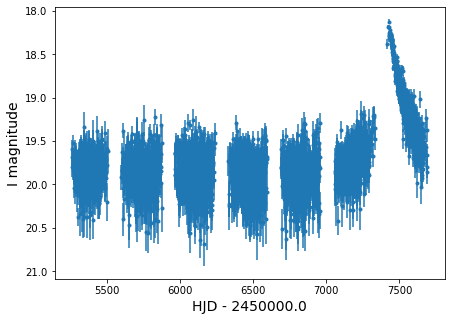

In [207]:
plt.rcParams['figure.figsize'] = (7.0, 5.0)
plt.errorbar(data['t'], data['I'], yerr=data['Ierr'], fmt='.');
plt.xlabel('HJD - '+str(data['t0']), fontsize=14);
plt.ylabel('I magnitude', fontsize=14);
plt.gca().invert_yaxis();

## Model

An excellent resource for gravitational lensing background (among other things) is [Peter Schneider's _Extragalactic Astronomy and Cosmology_](http://www.springer.com/us/book/9783642540820).[$^1$](#Note-1) In the 2015 edition, the relevant section for Galactic microlensing is 2.5 (page 77), and the equations defining the microlensing model lightcurve are 2.92 and 2.93. You don't actually need to read all this, but it can be nice to get some intuition about what's underneath the data.

The flux as a function of time, as enhanced by a microlensing event, is given by

$F(t) = F_0 \frac{y(t)^2 + 2}{y(t)\sqrt{y(t)^2+4}}$,

where

$y(t) = \sqrt{p^2 + \left( \frac{t-t_\mathrm{max}}{t_\mathrm{E}} \right)^2}$.

The parameters can be broadly interpretted as follows.
* $F_0$ is the flux in the absence of microlensing.
* $p$ is related to the impact parameter (in projection) of the lens as is passes in front of the star, so small $p$ implies more magnification.
* $t_\mathrm{max}$ is the time of maximum magnification.
* $t_\mathrm{E}$ sets the width of the enhancement in the lightcurve.

In practice, you'll also need the transformation between flux and magnitude, given above. For convenience, let's parameterize the normalization of the model lightcurve in magnitudes rather than flux, transforming $F(t)$ to $I(t)$ using the conversion above (with $I$ rather thasn $m$). We'll have $I_0$ rather than $F_0$ as a normalization parameter; this way, all of the "ref" quantities in the magnitude definition are absorbed into this new parameter and we won't have to worry about them explicitly. With that substitution, the model parameters are $I_0$, $p$, $t_\mathrm{max}$ and $t_\mathrm{E}$.

Using the equations above, implement a function predicting the $I$-band magnitude for a microlensing event as a function of $t$ given $I_0$, $p$, $t_\mathrm{max}$ and $t_\mathrm{E}$.
$F(t) = F_0 \frac{y(t)^2 + 2}{y(t)\sqrt{y(t)^2+4}}$,
where
$y(t) = \sqrt{p^2 + \left( \frac{t-t_\mathrm{max}}{t_\mathrm{E}} \right)^2}$. $m = m_\mathrm{ref} - 2.5\,\log_{10}\left(\frac{F}{F_\mathrm{ref}}\right)$

In [208]:
def model_I(t, I0, p, tmax, tE):
    yt=np.sqrt(p**2+((t-tmax)/tE)**2)
    Ft=(yt**2+2)/(yt*np.sqrt(yt**2+4))
    return I0-2.5*np.log(Ft)

By trial and error (possibly) plot a vaguely sensible model over the data (meaning that it goes through much of the data point cloud, not that it has to look great). You should be able to come up with broadly reasonable guesses at the parameter values by inspection, apart from $p$ which will be of order 1.

In [209]:
params = {'I0':19.8, 'p':4, 'tmax':7400, 'tE':400} 

paramnames = ['I0', 'p', 'tmax', 'tE']
param_labels = [r'$I_0$', r'$p$', r'$t_{max}$', r'$t_E$']

In [210]:
data['t0']

2450000.0

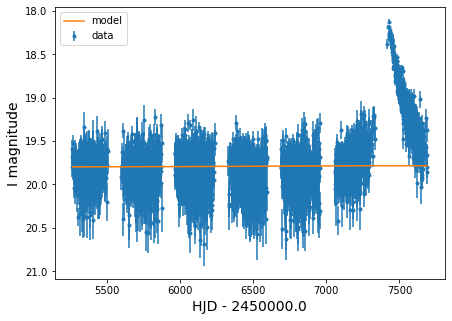

In [211]:
plt.rcParams['figure.figsize'] = (7.0, 5.0)
plt.errorbar(data['t'], data['I'], yerr=data['Ierr'], fmt='.', label='data', zorder=1);
plt.xlabel('HJD - '+str(data['t0']), fontsize=14);
plt.ylabel('I magnitude', fontsize=14);
plt.gca().invert_yaxis();
tgrid = np.linspace((data['t']).min(), (data['t']).max(), 1000)
plt.plot(tgrid, model_I(tgrid, **params), label='model', zorder=2);
plt.legend();

Now that the domain-specific calculations that we'll need are in hand, let's turn to specifying the generative model for these data. Lacking any better information, we'll assume that the sampling distributions for the magnitude measurements (the "magnitude" column) are Gaussian and independent, with means given by the model $I(t)$ and standard deviations given by the "magnitude error" column, and that the time stamps are exact.

First, we need to think about priors. As always, you can experiment with different choices if you think they're justified. But for concreteness, and to enable comparison with a known solution, consider the following as a default.

This seems like a situation where uniform priors are reasonable for all parameters. Note that $p\geq0$ is a physical requirement of the model definition (and $p>0$ is a numerical requirement, to avoid dividing by zero). Bounds for the prior distributions in $I_0$, $t_\mathrm{max}$ and $t_\mathrm{E}$ may not be obvious (strictly) a priori, but could be based on an absolutely minimal use of the data. For example, given that these lightcurves correspond to intervals the OGLE pipeline believes it found a microlensing event, it's reasonable to assume that $t_\mathrm{max}$ lies somewhere within the tabulated lightcurve, and similarly that the width $t_\mathrm{E}$ be less than the duration of the lightcurve, and that, for e.g., $I_0$ lies between the minimum and maximum of the measured $I(t)$ (maybe with an extra buffer of 1-2 magnitudes, if you want).

Having made some decision about the priors, sketch the PGM and write out the probability expressions for the complete model.

## Choose a sampling method

In this tutorial, we'd like you to stumble through the process of using one of the pre-packaged sampling methods available for the first time. Since they don't all work the same way, there isn't much supporting code we can provide below. For example, `emcee` will expect you to implement a log-posterior function similarly to what we have done before (on a [grid](toy_photometry_grid.ipynb) or with [Metropolis](toy_photometry_metro.ipynb)), while `pymc3` would have you encode the model in an abstract syntax that resembles the probability expressions you wrote above. We mention those two options because they (among others) been used by previous students, but you can choose something else out of the [list in the notes](../notes/MC_packages.ipynb), or indeed from elsewhere if you know of another option. Please don't use nested sampling, however, as you'll get to play with that anyway in the [Model Comparison](model_selection.ipynb) tutorial. If in doubt, drop us a line and ask.

It should go without saying, but do not use a method that you don't at least somewhat understand. If you choose something that wasn't covered [in the notes](../notes/more_samplers.ipynb), include a brief description of the method below to demonstrate that it isn't a complete mystery.

I will be using `emcee`

## Do the thing

You're on your own for a bit. Implement the inference as guided by the documentation for your chosen sampler and make it happen! Please remember to **document** what you're doing in Markdown as you go, rather than relying on "self-explanatory" code or inline comments.

## Look at diagnostics

If your chosen method produces independent chains like we have used before, or something that can be coerced into that form (e.g. walkers from independent `emcee` runs), use the code below to inspect parameter traces, remove burn-in and so on, as we have done previously. If your method is sufficiently different that some of those steps don't make sense, it will doubtless still come with some documented approach to verifying that the calculations completed successfully. In that case, perform the appropriate checks, providing some explanation of what is being shown.

The code below assumes that the original chains are in a list of `Nsteps` $\times$ `Nparams` arrays, called `chains`, as we've done before.

Using the equations above, implement a function predicting the $I$-band magnitude for a microlensing event as a function of $t$ given $I_0$, $p$, $t_\mathrm{max}$ and $t_\mathrm{E}$.
$F(t) = F_0 \frac{y(t)^2 + 2}{y(t)\sqrt{y(t)^2+4}}$,
where
$y(t) = \sqrt{p^2 + \left( \frac{t-t_\mathrm{max}}{t_\mathrm{E}} \right)^2}$. $I = I_0 - 2.5\,\log_{10}\left(\frac{F}{F_0}\right)$

In [346]:
params = {'I0':19.8, 'p':0.6, 'tmax':7650, 'tE':200} 

In [347]:
data['I']-model_I(data['t'], **params)

array([-7.62363747e-04, -1.13762345e-01, -2.07761996e-01, ...,
        1.34148193e+00,  1.47574740e+00,  1.52894513e+00])

In [348]:
def log_prior(theta):
    I0, p, tmax, tE = theta
    if 19<I0<21 and 0.5 < p < 1.0 and 7600 < tmax < 8000 and 190 <tE <220:
        return 0.0
    return -np.inf
def model_I(t, I0, p, tmax, tE):
    yt=np.sqrt(p**2+((t-tmax)/tE)**2)
    Ft=(yt**2+2)/(yt*np.sqrt(yt**2+4))
    return I0-2.5*np.log(Ft)
def log_likelihood(theta, t, I, Ierr):
    I0, p, tmax, tE = theta
    modelI = model_I(t, I0, p, tmax, tE) 
    return -0.5 * np.sum((I-modelI)**2/Ierr**2)
def log_probability(theta, t, I, Ierr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, I, Ierr)

In [349]:
guess = params
guessvec = list(guess.values())
guessvec

[19.8, 0.6, 7650, 200]

In [350]:
nwalkers = 16
ndims=4
guess = params
guessvec = list(guess.values()) # it will be useful to have `guess` as a vector also
start = np.array([np.array(guessvec)*(1.0 + 0.01*np.random.randn(ndims)) for j in range(nwalkers)])
import emcee
sampler = emcee.EnsembleSampler(
    nwalkers, ndims, log_probability, 
    args=(data['t'],data['I'],data['Ierr'])
)
sampler.run_mcmc(start, 5000, progress=True);

You must install the tqdm library to use progress indicators with emcee
/home/ohj/.local/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


In [351]:
chains=sampler.get_chain()

In [352]:
param_labels=['$I_0$','$p$', '$t_{max}$', '$t_E$']

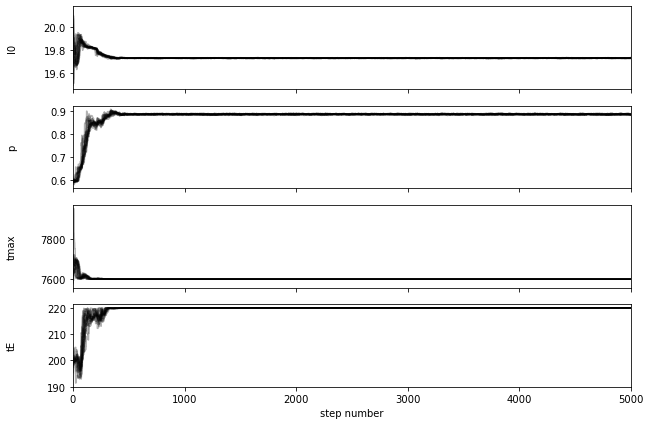

In [353]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
labels = ['I0',"p", "tmax", "tE"]
for i in range(ndims):
    ax = axes[i]
    ax.plot(chains[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(chains))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

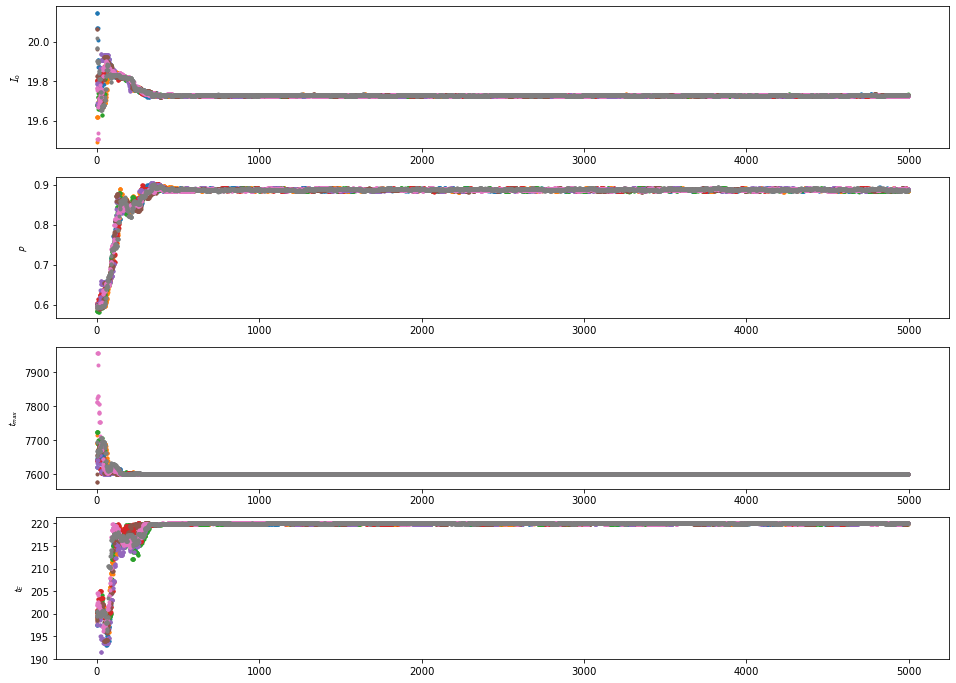

In [354]:
# look at trace plots
npars = len(guess)
plt.rcParams['figure.figsize'] = (16.0, 3.0*npars)
fig, ax = plt.subplots(npars, 1);
cr.plot_traces(sampler.chain[:min(8,nwalkers),:,:npars], ax, labels=param_labels+[r'$M_1$']);

In [355]:
# Gelman-Rubin convergence
cr.GelmanRubinR(chains)

array([2.14905834, 7.54140755, 1.83144593, 4.71921639])

In [356]:
#Burn some
burn = 300
maxlag = 2000

tmp_samples = [sampler.chain[i,burn:,:4] for i in range(nwalkers)]
print('R =', cr.GelmanRubinR(tmp_samples))
print('neff =', cr.effective_samples(tmp_samples, maxlag=maxlag))

R = [1.0042691  1.00616618 1.00023499 1.00191498]
neff = [109.30487152 133.38017681  53.56560071  54.10327717]


In [357]:
np.array(tmp_samples).shape

(16, 4700, 4)

In [358]:
tmp_samples=np.array(tmp_samples)
tmp_samples.reshape(4700,16, 4)

array([[[1.97308923e+01, 8.91012842e-01, 7.60103497e+03, 2.19009845e+02],
        [1.97308923e+01, 8.91012842e-01, 7.60103497e+03, 2.19009845e+02],
        [1.97308923e+01, 8.91012842e-01, 7.60103497e+03, 2.19009845e+02],
        ...,
        [1.97239800e+01, 8.97578410e-01, 7.60086476e+03, 2.19771362e+02],
        [1.97239800e+01, 8.97578410e-01, 7.60086476e+03, 2.19771362e+02],
        [1.97239800e+01, 8.97578410e-01, 7.60086476e+03, 2.19771362e+02]],

       [[1.97239800e+01, 8.97578410e-01, 7.60086476e+03, 2.19771362e+02],
        [1.97239800e+01, 8.97578410e-01, 7.60086476e+03, 2.19771362e+02],
        [1.97239800e+01, 8.97578410e-01, 7.60086476e+03, 2.19771362e+02],
        ...,
        [1.97264251e+01, 8.94212447e-01, 7.60090683e+03, 2.19787654e+02],
        [1.97296418e+01, 8.95116080e-01, 7.60070261e+03, 2.19793859e+02],
        [1.97318233e+01, 8.95728919e-01, 7.60056411e+03, 2.19798068e+02]],

       [[1.97331107e+01, 8.95088838e-01, 7.60053466e+03, 2.19811228e+02],
        

In [359]:
samples = np.concatenate(tmp_samples, axis=0)

In [360]:
samples.shape

(75200, 4)

For compatibility with the remainder of the notebook, store your final list of samples in a single $N\times4$ array called `samples`. This is done above for the multiple Markov chain case, but if your sampler was different then you may need to go through other contortions (or maybe none) to produce such an array. Make sure the columns of `samples` have the parameters in the order given by `paramnames`

## Evaluate the fit

As a simple check of whether the fit is reasonable, the cell below will plot the model curve defined by the posterior mean over the data. We can't possibly claim to be finished without looking at this!

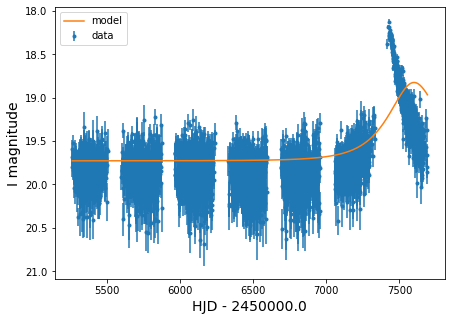

In [361]:
mean_params = np.mean(samples, axis=0)

plt.rcParams['figure.figsize'] = (7.0, 5.0)
plt.errorbar(data['t'], data['I'], yerr=data['Ierr'], fmt='.', label='data', zorder=1);
plt.xlabel('HJD - '+str(data['t0']), fontsize=14);
plt.ylabel('I magnitude', fontsize=14);
plt.gca().invert_yaxis();
tgrid = np.linspace(data['t'].min(), data['t'].max(), 1000)
plt.plot(tgrid, model_I(tgrid, *mean_params), label='model', zorder=2);
plt.legend();

**Checkpoint:** Hopefully it looks reasonable.

To get a sense of the range of curve consistent with the posterior, let's repeat this plot, showing a random sampling of several posterior samples.

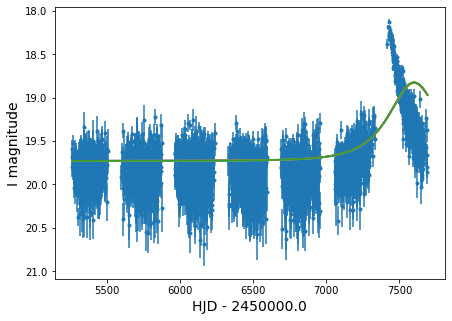

In [362]:
plt.rcParams['figure.figsize'] = (7.0, 5.0)
plt.errorbar(data['t'], data['I'], yerr=data['Ierr'], fmt='.', label='data', zorder=1);
plt.xlabel('HJD - '+str(data['t0']), fontsize=14);
plt.ylabel('I magnitude', fontsize=14);
plt.gca().invert_yaxis();
tgrid = np.linspace(data['t'].min(), data['t'].max(), 1000)
for i in np.linspace(0, samples.shape[0]-1, 12):
    plt.plot(tgrid, model_I(tgrid, *samples[int(i),:]), zorder=2);

... but the answer seems to be (**checkpoint**) that they are too similar to even distinguish.

We could go on and do a quantitative goodness-of-fit test, but this case seems straightforward enough. We'll delve into such things more in other tutorials.

## Summary of results

Similarly, we're not done without finding the 1D marginalized best values and 68.3% credible intervals for each parameter. But first, let's have a look at the triangle.

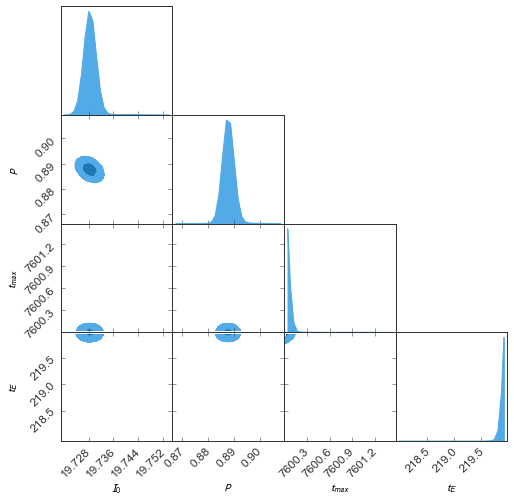

In [363]:
plotGTC(samples, paramNames=param_labels, figureSize=8, customLabelFont={'size':12}, customTickFont={'size':12});

**Checkpoint:** For the reference data set and priors, I find (with one particular set of chains) $I_0=19.8230\pm0.0017$, $p=0.2664\pm0.0013$, $t_\mathrm{max}=7434.4\pm0.4$ and $t_\mathrm{E}=194.6\pm1.0$. Keep in mind you may see some difference in the fine digits, even if everything is fine.

## Parting words

By this point, hopefully you feel like you're getting the hang of sampling from and evaluating posterior distributions, and checking that the results are reasonable. We'll also have some tutorials that focus more on model evaluation and comparison, and then it's on to practicing with more complex, real-world inference problems!

#### Endnotes

##### Note 1

From within the Stanford network, it should be possible to download the PDF directly through the link above. From outside, you would need to use the Stanford libraries browser extension detailed on the [Stanford library e-resources page](https://library.stanford.edu/using/connect-e-resources). Either way, you don't actually **need** to get the book; the key information is reproduced here.